In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy import wcs
from astropy import units as u

In [4]:
aperture_file = r'C:/Users/lukeb/Documents/MPhys_RRLs/output_files/aperphot21_channel1.txt'
psf_file = r'C:/Users/lukeb/Documents/MPhys_RRLs/output_files/psfphot01_test.txt'

image = 'PAL5_data/PAL5/PAL5_3p6um.fits'
data = fits.getdata(image, ext = 0)

aper_data = ascii.read(aperture_file, delimiter = ',')
psf_data = ascii.read(psf_file, delimiter = ',')
print(aper_data)
print(psf_data)

 id      xcenter            ycenter          apparent_mag   
--- ------------------ ------------------ ------------------
  1  1269.306438658434 28.508046322300604 17.454891767921815
  2  1140.101496447641   29.8954302843011 17.351849682550643
  3  1302.347304730968  30.39722058572406 16.343448596643498
  4  799.4731334237919 39.357216167029925                nan
  5 1264.0199410121636  40.40395391057569  17.83538129255546
  6  912.2296121265201  40.46301459629582 17.664629532631377
  7 1151.8759767787662 42.267177657717994 15.139341766994471
  8  598.5167649625747   42.8952752294084 16.806878499451134
  9 388.36815616923667  44.40852434477962  14.06731672350931
 10  434.6517156832254 45.887198961276404 15.560542716424283
...                ...                ...                ...
817  1145.221673746733  653.9024837177809 17.304547795319962
818  980.5674143242292  655.5975427416694                nan
819  900.1800221103883  656.3799649559895                nan
820  362.5339901675963  

In [5]:
header_list = fits.open(image)
header = header_list[0].header
header_list.close()

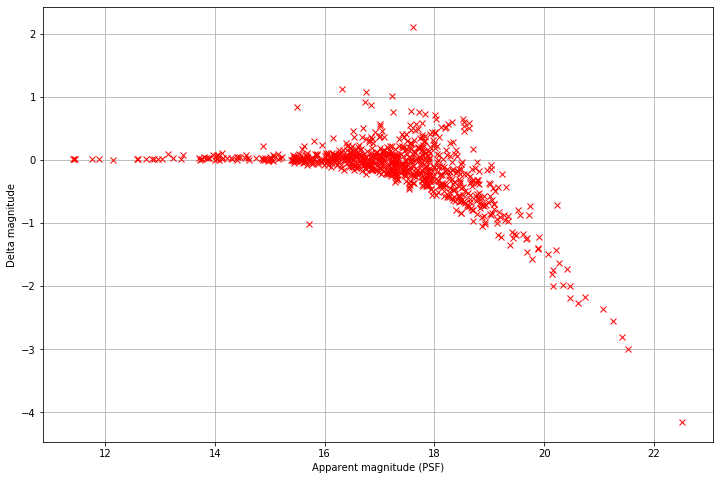

In [15]:
w = wcs.WCS(header)
#print(w)

aper_x = aper_data['xcenter']
aper_y = aper_data['ycenter']
psf_x = psf_data['x_0']
psf_y = psf_data['y_0']

aper_coord = np.transpose((aper_x, aper_y))
psf_coord = np.transpose((psf_x, psf_y))

aper_world = w.wcs_pix2world(aper_coord, 0)
psf_world = w.wcs_pix2world(psf_coord, 0)

aper_ra = aper_world[:, 0]
aper_dec = aper_world[:, 1]
psf_ra = psf_world[:, 0]
psf_dec = psf_world[:, 1]

aper_c = SkyCoord(aper_ra, aper_dec, frame = 'icrs', unit = 'deg')
psf_c = SkyCoord(psf_ra, psf_dec, frame = 'icrs', unit = 'deg')

idx, d2d, d3d = psf_c.match_to_catalog_sky(aper_c)

# append new ra and dec coordinates to existing files
aper_data['ra'] = aper_ra
aper_data['dec'] = aper_dec
psf_data['ra'] = psf_ra
psf_data['dec'] = psf_dec

# following tutorial, must ensure any matches are significant
radius = 0.0001
selection = (d2d > radius*u.deg)
match_index = idx
match_index[selection] = -99.

matches = (match_index >= 0)

aper_mag = aper_data['apparent_mag'][match_index][matches]
psf_mag = psf_data['apparent_mag'][matches]
delta_mag = aper_mag - psf_mag

plt.plot(psf_mag, delta_mag, 'rx')
plt.xlabel('Apparent magnitude (PSF)')
plt.ylabel('Delta magnitude')
plt.grid()
plt.gcf().set_size_inches(12, 8)
plt.show()